In [1]:
from __future__ import print_function

import os
import json
import shutil
import numpy as np

from utils import prepare_data

from keras.models import Model, load_model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, \
                            precision_recall_curve, average_precision_score, confusion_matrix

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Using TensorFlow backend.


In [2]:
sns.set(style="whitegrid", font_scale=1.3)

In [3]:
matplotlib.rcParams["legend.framealpha"] = 1
matplotlib.rcParams["legend.frameon"] = True
matplotlib.rcParams["legend.fontsize"] = 14

matplotlib.rcParams["figure.figsize"] = (10, 8)
matplotlib.rcParams["font.size"] = 14

matplotlib.rcParams["xtick.labelsize"] = 14
matplotlib.rcParams["ytick.labelsize"] = 14

matplotlib.rcParams["axes.labelsize"] = 18
matplotlib.rcParams["axes.titlesize"] = 20

# Data

In [4]:
data_path = "../data"
models_path = "../models"
valid_size = 0.2
FORCED_DATA_REWRITE = False

In [5]:
train_path, valid_path = prepare_data(data_path=data_path, 
                                      valid_size=valid_size, 
                                      FORCED_DATA_REWRITE=FORCED_DATA_REWRITE)

In [6]:
train_neg_path = os.path.join(train_path, "Negative")
train_pos_path = os.path.join(train_path, "Positive")
valid_neg_path = os.path.join(valid_path, "Negative")
valid_pos_path = os.path.join(valid_path, "Positive")

In [7]:
n_examples = 5

In [8]:
np.random.seed(42)
positive_expamples = np.random.choice(os.listdir(train_pos_path), size=n_examples, replace=False)
negative_expamples = np.random.choice(os.listdir(train_neg_path), size=n_examples, replace=False)

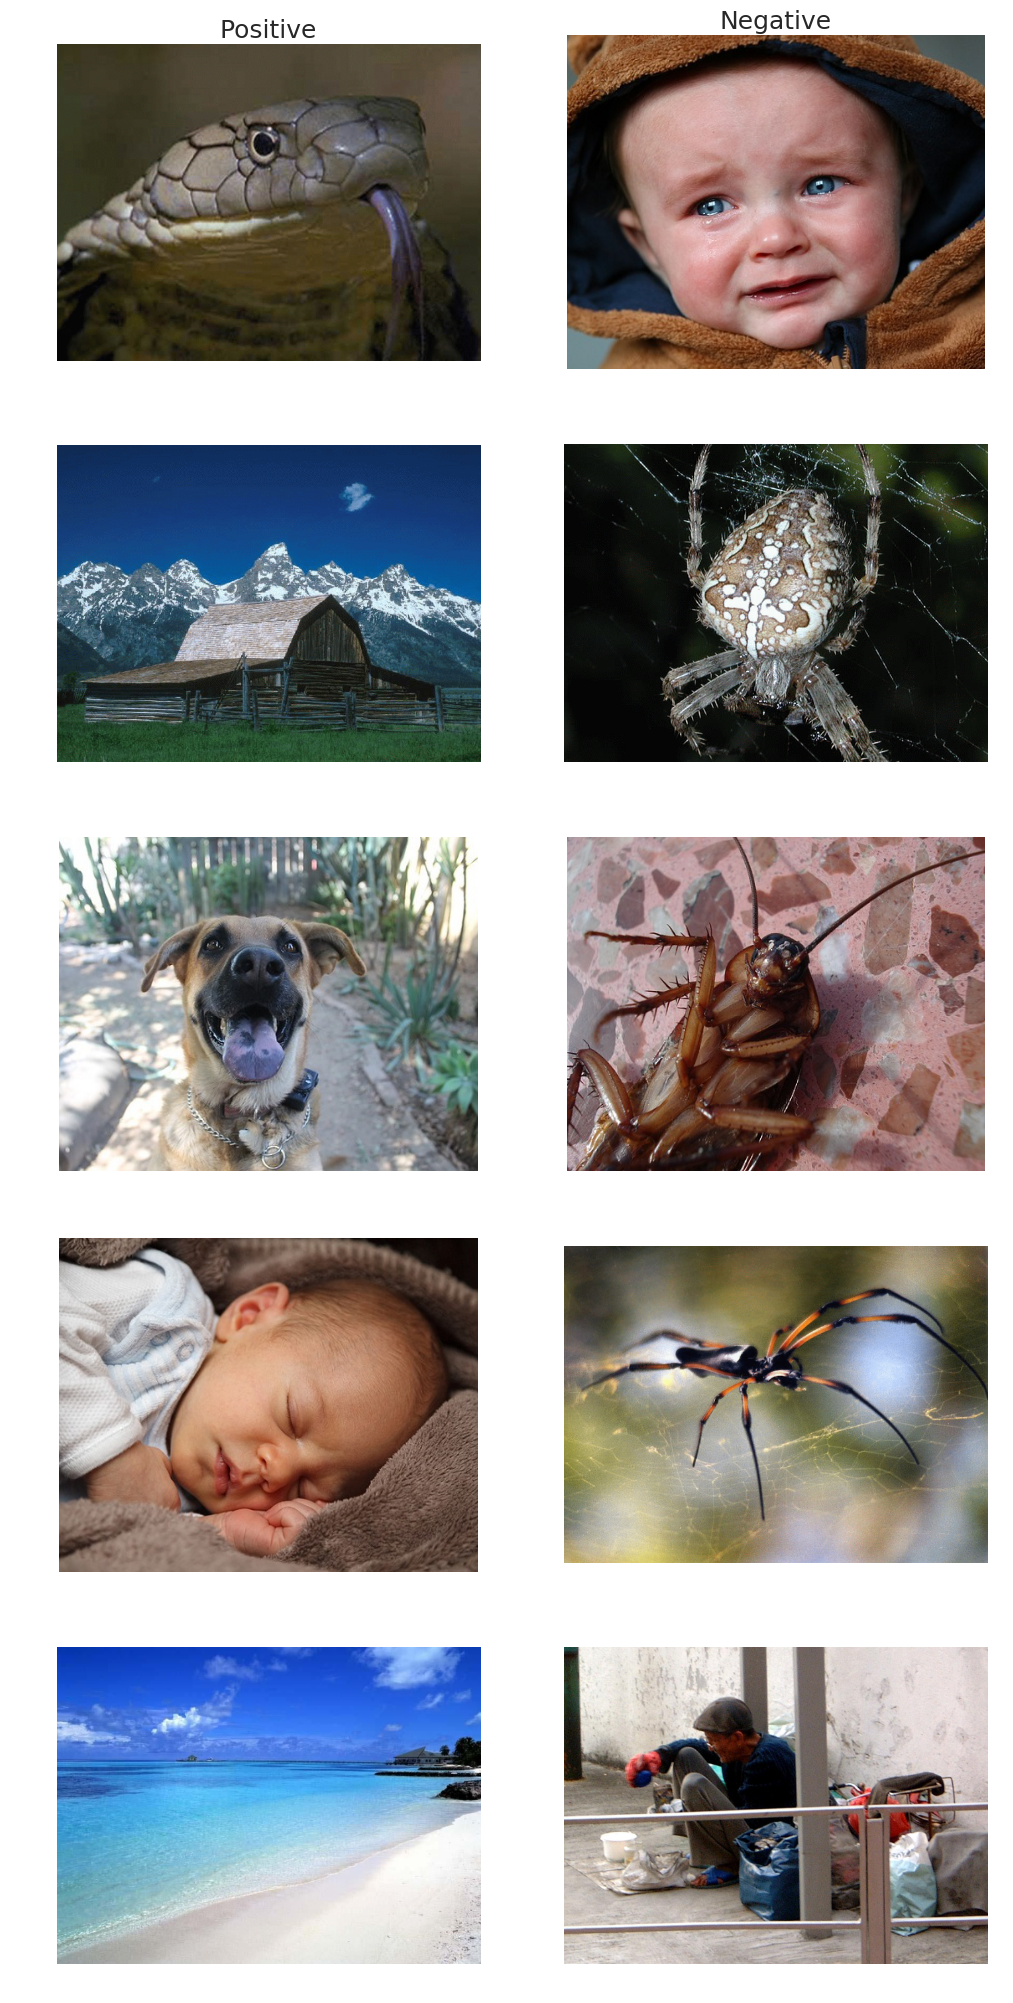

In [9]:
plt.figure(figsize=(12, n_examples * 5))
for i in range(n_examples):
    plt.subplot(n_examples, 2, i * 2 + 1)
    img = load_img(os.path.join(train_pos_path, positive_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Positive", fontsize=18)
    plt.subplot(n_examples, 2, i * 2 + 2)
    img = load_img(os.path.join(train_neg_path, negative_expamples[i]))
    plt.imshow(img)
    plt.axis("off")
    if i == 0:
        plt.title("Negative", fontsize=18)

In [10]:
img_height, img_width = 400, 500

# CNN from scratch

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40, 
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")
valid_datagen =  ImageDataGenerator(rescale=1./255)

In [12]:
train_gen = train_datagen.flow_from_directory(train_path, 
                                              target_size=(img_height, img_width), 
                                              class_mode="binary", 
                                              batch_size=32, 
                                              shuffle=True, 
                                              seed=21)

valid_gen = valid_datagen.flow_from_directory(valid_path, 
                                              target_size=(img_height, img_width), 
                                              class_mode="binary", 
                                              batch_size=32, 
                                              shuffle=False, 
                                              seed=21)

Found 1305 images belonging to 2 classes.
Found 325 images belonging to 2 classes.


In [13]:
train_gen.class_indices

{'Negative': 0, 'Positive': 1}

In [14]:
LOAD_BASELINE_MODEL = True

In [15]:
if LOAD_BASELINE_MODEL:
    
    try:
        model_baseline = load_model(os.path.join(models_path, "baseline.model"))
        print("Model has been loaded!")
    except:
        LOAD_BASELINE_MODEL = False
        print("Load has failed. Model will be built from scratch.")
        
if not LOAD_BASELINE_MODEL:
    
    inp = Input(shape=train_gen.target_size + (3,))

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2))(inp)
    conv2 = Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2))(conv1)
    maxpool1 = MaxPool2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2))(maxpool1)
    conv4 = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2))(conv3)
    maxpool2 = MaxPool2D(pool_size=(2, 2))(conv4)

    flattened = Flatten()(maxpool2)
    
    fc1 = Dense(units=256, activation="relu", 
                kernel_initializer="he_normal")(flattened)
    dp1 = Dropout(rate=0.5)(fc1)
    
    fc2 = Dense(units=512, activation="relu", 
                kernel_initializer="he_normal")(dp1)
    dp2 = Dropout(rate=0.5)(fc2)
    
    out = Dense(units=1, activation="sigmoid")(dp2)
    
    model_baseline = Model(inputs=[inp], outputs=[out])
    
    model_baseline.compile(optimizer="Adam", 
                           loss="binary_crossentropy", 
                           metrics=["accuracy"])
    
    print("Model has been built.")

Model has been built.


In [16]:
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 400, 500, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 199, 249, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 99, 124, 64)       36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 49, 62, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 30, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 7, 128)         0         
__________

In [17]:
train_steps_per_epoch = int(np.ceil(train_gen.n * 1. / train_gen.batch_size))
valid_steps_per_epoch = int(np.ceil(valid_gen.n * 1. / valid_gen.batch_size))

In [18]:
if not LOAD_BASELINE_MODEL:
    hist_baseline = model_baseline.fit_generator(train_gen, 
                                                 steps_per_epoch=train_steps_per_epoch, 
                                                 epochs=10, 
                                                 validation_data=valid_gen, 
                                                 validation_steps=valid_steps_per_epoch)
    model_baseline.save(os.path.join(models_path, "baseline.model"))
    json.dump(hist_baseline.history, open(os.path.join(models_path, "baseline.hist"), "w"))
    hist_baseline = hist_baseline.history
else:
    hist_baseline = json.load(open(os.path.join(models_path, "baseline.hist"), "r"))
    print("Model has already been trained.")

/opt/conda/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:2252: UserWarning: Expected no kwargs, you passed 1
kwargs passed to function are ignored with Tensorflow backend
  warnings.warn('\n'.join(msg))


Epoch 1/10
41/41 [==============================] - 39s - loss: 0.7418 - acc: 0.5055 - val_loss: 0.6880 - val_acc: 0.5046
Epoch 2/10
41/41 [==============================] - 35s - loss: 0.7276 - acc: 0.5218 - val_loss: 0.6954 - val_acc: 0.5200
Epoch 3/10
41/41 [==============================] - 35s - loss: 0.7186 - acc: 0.5234 - val_loss: 0.6924 - val_acc: 0.5354
Epoch 4/10
41/41 [==============================] - 36s - loss: 0.7316 - acc: 0.4994 - val_loss: 0.6877 - val_acc: 0.5262
Epoch 5/10
41/41 [==============================] - 36s - loss: 0.7159 - acc: 0.5005 - val_loss: 0.6907 - val_acc: 0.5231
Epoch 6/10
41/41 [==============================] - 35s - loss: 0.7081 - acc: 0.5100 - val_loss: 0.6874 - val_acc: 0.4738
Epoch 7/10
41/41 [==============================] - 36s - loss: 0.7088 - acc: 0.5113 - val_loss: 0.6933 - val_acc: 0.4892
Epoch 8/10
41/41 [==============================] - 36s - loss: 0.7044 - acc: 0.4863 - val_loss: 0.6962 - val_acc: 0.4831
Epoch 9/10
41/41 [======

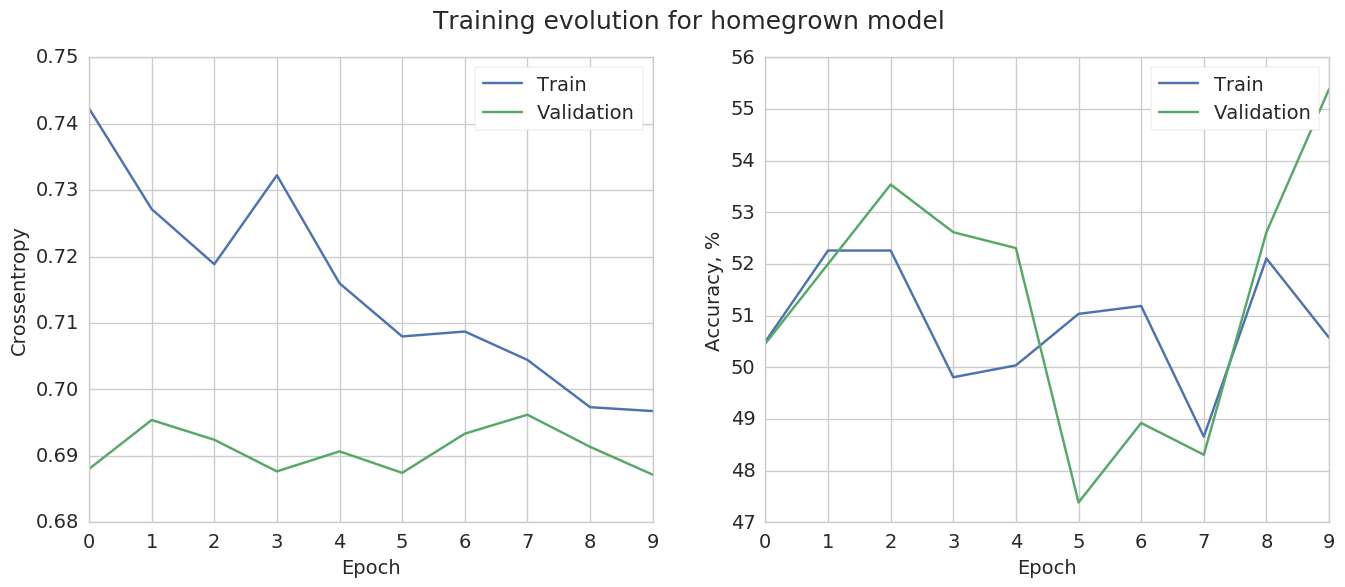

In [19]:
plt.figure(figsize=(16, 6))
plt.suptitle("Training evolution for homegrown model", fontsize=18)

plt.subplot(121)
plt.plot(hist_baseline["loss"], label="Train")
plt.plot(hist_baseline["val_loss"], label="Validation")
plt.legend()
plt.ylabel("Crossentropy", fontsize=14)
plt.xlabel("Epoch", fontsize=14)

plt.subplot(122)
plt.plot(np.array(hist_baseline["acc"]) * 100, label="Train")
plt.plot(np.array(hist_baseline["val_acc"]) * 100, label="Validation")
plt.legend()
plt.ylabel("Accuracy, %", fontsize=14)
plt.xlabel("Epoch", fontsize=14);

In [20]:
y_pred = model_baseline.predict_generator(valid_gen, valid_steps_per_epoch)
y_valid = np.array(valid_gen.classes)

In [21]:
print(classification_report(y_valid, y_pred.flatten() > 0.5))
print("Accuracy = {:.1f}%".format(accuracy_score(y_valid, y_pred.flatten() > 0.5) * 100))

             precision    recall  f1-score   support

          0       0.59      0.19      0.29       154
          1       0.55      0.88      0.67       171

avg / total       0.57      0.55      0.49       325

Accuracy = 55.4%


In [22]:
conf_mat = confusion_matrix(y_valid, y_pred.flatten() > 0.5)
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

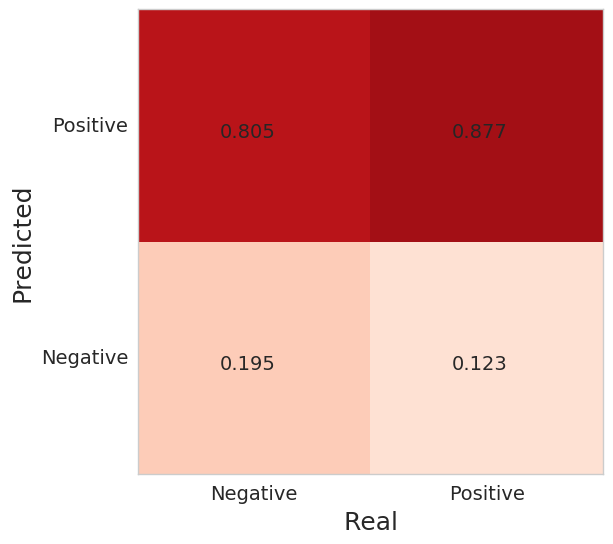

In [23]:
plt.figure(figsize=(6, 6))
plt.pcolor(conf_mat.T, cmap=plt.cm.Reds, vmin=0.0, vmax=1.0)
ax = plt.gca()
ax.set_xticklabels(["Negative", "Positive"], minor=False)
ax.set_yticklabels(["Negative", "Positive"], minor=False)
ax.set_xticks(np.arange(2) + 0.5, minor=False)
ax.set_yticks(np.arange(2) + 0.5, minor=False)
ax.set_xlabel("Real")
ax.set_ylabel("Predicted")
for i in range(2):
    for j in range(2):
        plt.text(i + 0.35, j + 0.45, str(round(conf_mat[i, j], 3)))

In [24]:
roc = roc_curve(y_valid, y_pred.flatten())

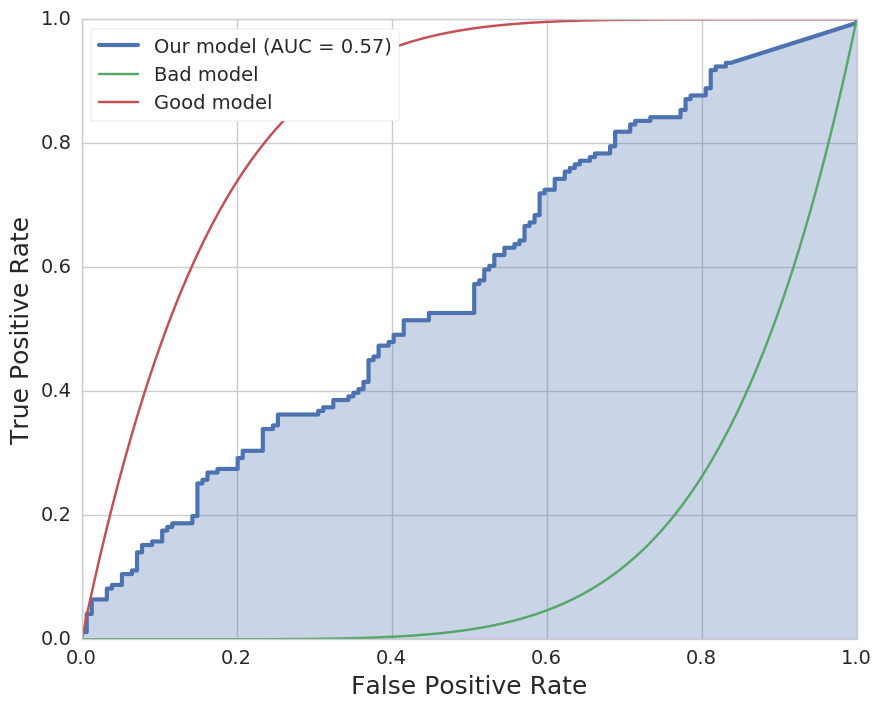

In [25]:
plt.plot(roc[0], roc[1], 
         label="Our model (AUC = {:.2f})".format(roc_auc_score(y_valid, y_pred.flatten())), 
         lw=3)
xx = np.arange(0, 1, 0.001)
plt.plot(xx, xx ** 6, label="Bad model")
plt.plot(xx, -(xx - 1) ** 6 + 1, label="Good model")
plt.fill_between(roc[0], 0, roc[1], alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.legend(loc=2);